<a href="https://colab.research.google.com/github/Jorgecardetegit/computer_vision_peripheral_blood/blob/main/EDA_computerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
directory_path = "/content/drive/MyDrive/peripheral blood dataset"

In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rescale=1./255)

In [ ]:
ds = data_gen.flow_from_directory(
    directory=directory_path,
    seed=123,
    target_size=(360,363),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

Found 1328 images belonging to 7 classes.


In [ ]:
class_labels = ds.class_indices
class_counts = {class_name: 0 for class_name in class_labels.keys()}

In [ ]:
for class_index in ds.classes:
    class_name = list(class_labels.keys())[list(class_labels.values()).index(class_index)]
    class_counts[class_name] += 1

# Print the counts
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Chronic Lymphotic Leuchemia: 38
Folicular Lymphoma: 680
Lymphoblastic Lymphoma: 540
Marginal Lymphocites: 144
Mononucleosis: 202
Normal Lymphocites: 486
Tricholeukemia: 566


In [ ]:
import matplotlib.pyplot as plt

# Get class names and counts
class_names = list(class_counts.keys())
counts = list(class_counts.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.title('Distribution of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()

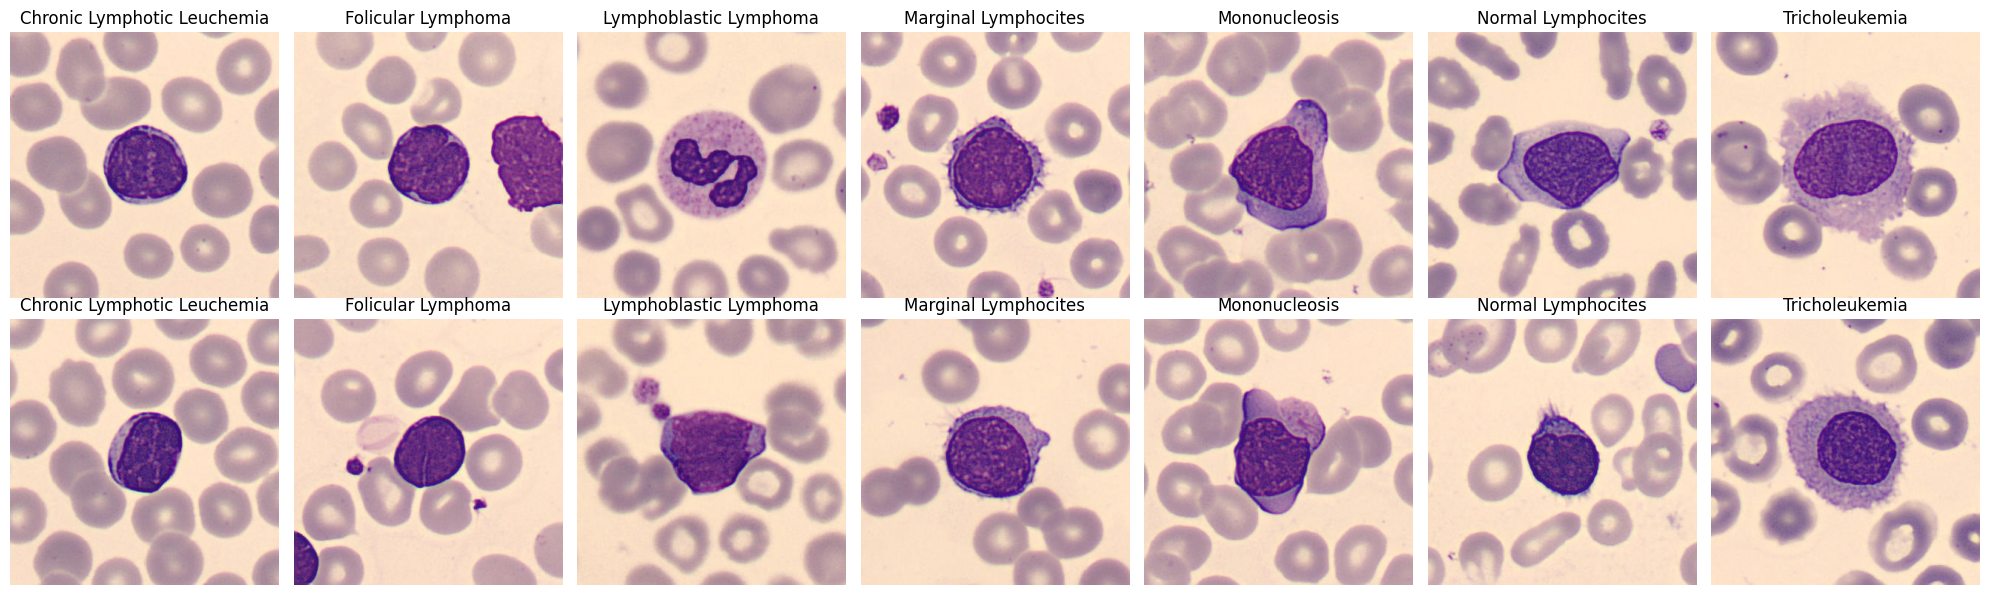

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img

# Define the number of samples to display per class
samples_per_class = 2

# Initialize a dictionary to keep track of samples shown for each class
samples_shown = {class_name: 0 for class_name in class_labels.keys()}

# Create a figure and axes for the plot
n_classes = len(class_labels)
fig, axes = plt.subplots(samples_per_class, n_classes, figsize=(20, samples_per_class * 3))
axes = axes.flatten() # Flatten the axes array for easy indexing

# Iterate through the dataset
for images, labels in ds:
    for img_array, label in zip(images, labels):
        class_index = int(label)
        class_name = list(class_labels.keys())[class_index]

        # Check if we need more samples for this class
        if samples_shown[class_name] < samples_per_class:
            # Convert the array to an Image object
            img = array_to_img(img_array)

            # Calculate the index for the subplot
            row_index = samples_shown[class_name]
            col_index = class_index
            ax_index = row_index * n_classes + col_index

            # Display the image
            axes[ax_index].imshow(img)
            axes[ax_index].set_title(class_name)
            axes[ax_index].axis('off')

            # Increment the counter for this class
            samples_shown[class_name] += 1

    # Check if we have collected enough samples for all classes
    if all(count >= samples_per_class for count in samples_shown.values()):
        break

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Initialize sums and counts for mean calculation
sum_pixels = np.zeros(3)  # Assuming RGB images
total_pixels = 0

# Initialize sums for standard deviation calculation
sum_sq_diff = np.zeros(3)

# Iterate through the dataset
for images, labels in ds:
    # Assuming images are in the format (batch_size, height, width, channels)
    batch_size, height, width, channels = images.shape

    # Reshape images to (batch_size * height * width, channels) for easier calculation
    reshaped_images = images.reshape(-1, channels)

    # Calculate sum of pixels for the current batch
    sum_pixels += np.sum(reshaped_images, axis=0)

    # Update total number of pixels
    total_pixels += reshaped_images.shape[0]


# Calculate the mean pixel values
mean_pixels = sum_pixels / total_pixels

# Reset total_pixels for standard deviation calculation
total_pixels = 0

# Iterate through the dataset again to calculate sum of squared differences
for images, labels in ds:
    batch_size, height, width, channels = images.shape
    reshaped_images = images.reshape(-1, channels)

    # Calculate sum of squared differences from the mean for the current batch
    sum_sq_diff += np.sum((reshaped_images - mean_pixels)**2, axis=0)

    # Update total number of pixels
    total_pixels += reshaped_images.shape[0]

# Calculate the standard deviation
std_pixels = np.sqrt(sum_sq_diff / total_pixels)

print(f"Mean pixel values per channel (RGB): {mean_pixels}")
print(f"Standard deviation of pixel values per channel (RGB): {std_pixels}")

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store histogram data for each channel
hist_r = []
hist_g = []
hist_b = []

# Iterate through the dataset
for images, labels in ds:
    for img_array in images:
        # Convert from RGB to BGR for OpenCV
        img_bgr = cv2.cvtColor(np.uint8(img_array * 255), cv2.COLOR_RGB2BGR)

        # Calculate histograms for each channel
        hist_r.extend(cv2.calcHist([img_bgr], [2], None, [256], [0, 256]).flatten())
        hist_g.extend(cv2.calcHist([img_bgr], [1], None, [256], [0, 256]).flatten())
        hist_b.extend(cv2.calcHist([img_bgr], [0], None, [256], [0, 256]).flatten())

# Convert lists to numpy arrays for easier plotting
hist_r = np.array(hist_r)
hist_g = np.array(hist_g)
hist_b = np.array(hist_b)

# Plot the aggregated histograms
plt.figure(figsize=(10, 6))
plt.plot(hist_r, color='red', label='Red channel')
plt.plot(hist_g, color='green', label='Green channel')
plt.plot(hist_b, color='blue', label='Blue channel')
plt.title('Aggregated Color Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img
import numpy as np

# Define the classes to compare and the number of samples per class
class_1_name = 'Tricholeukemia'
class_2_name = 'Lymphoblastic Lymphoma'
samples_to_show = 4

# Get the class indices
class_1_index = ds.class_indices[class_1_name]
class_2_index = ds.class_indices[class_2_name]

# Initialize lists to store images for each class
class_1_images = []
class_2_images = []

# Iterate through the dataset to find images for the selected classes
for images, labels in ds:
    for img_array, label in zip(images, labels):
        class_index = int(label)

        if class_index == class_1_index and len(class_1_images) < samples_to_show:
            class_1_images.append(img_array)
        elif class_index == class_2_index and len(class_2_images) < samples_to_show:
            class_2_images.append(img_array)

    # Stop if we have enough images for both classes
    if len(class_1_images) == samples_to_show and len(class_2_images) == samples_to_show:
        break

# Create a figure and axes for the plot
fig, axes = plt.subplots(2, samples_to_show, figsize=(15, 6))

# Display images for the first class
for i, img_array in enumerate(class_1_images):
    img = array_to_img(img_array)
    axes[0, i].imshow(img)
    axes[0, i].set_title(class_1_name)
    axes[0, i].axis('off')

# Display images for the second class
for i, img_array in enumerate(class_2_images):
    img = array_to_img(img_array)
    axes[1, i].imshow(img)
    axes[1, i].set_title(class_2_name)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()